In [1]:
import pm4py
log_all = pm4py.read_xes('BPI_Challenge_2012.xes')

parsing log, completed traces ::   0%|          | 0/13087 [00:00<?, ?it/s]

In [2]:
print(f'activities: {sorted(list(pm4py.get_event_attribute_values(log_all,"concept:name").keys()))}')

activities: ['A_ACCEPTED', 'A_ACTIVATED', 'A_APPROVED', 'A_CANCELLED', 'A_DECLINED', 'A_FINALIZED', 'A_PARTLYSUBMITTED', 'A_PREACCEPTED', 'A_REGISTERED', 'A_SUBMITTED', 'O_ACCEPTED', 'O_CANCELLED', 'O_CREATED', 'O_DECLINED', 'O_SELECTED', 'O_SENT', 'O_SENT_BACK', 'W_Afhandelen leads', 'W_Beoordelen fraude', 'W_Completeren aanvraag', 'W_Nabellen incomplete dossiers', 'W_Nabellen offertes', 'W_Valideren aanvraag', 'W_Wijzigen contractgegevens']


In [3]:
# We only look at subtraces of activities starting with an 'O'.
log = pm4py.filter_event_attribute_values(
    log_all,
    "concept:name",
    ['O_ACCEPTED', 'O_CANCELLED', 'O_CREATED', 'O_DECLINED', 'O_SELECTED', 'O_SENT', 'O_SENT_BACK'],
    level="event",
    retain=True)


In [4]:
pm4py.write_xes(log, "BPI Challenge 2012 only O.xes")

exporting log, completed traces ::   0%|          | 0/5015 [00:00<?, ?it/s]

### Analysis

In [31]:
import pm4py
log = pm4py.read_xes('BPI Challenge 2012 only O.xes')

parsing log, completed traces ::   0%|          | 0/5015 [00:00<?, ?it/s]

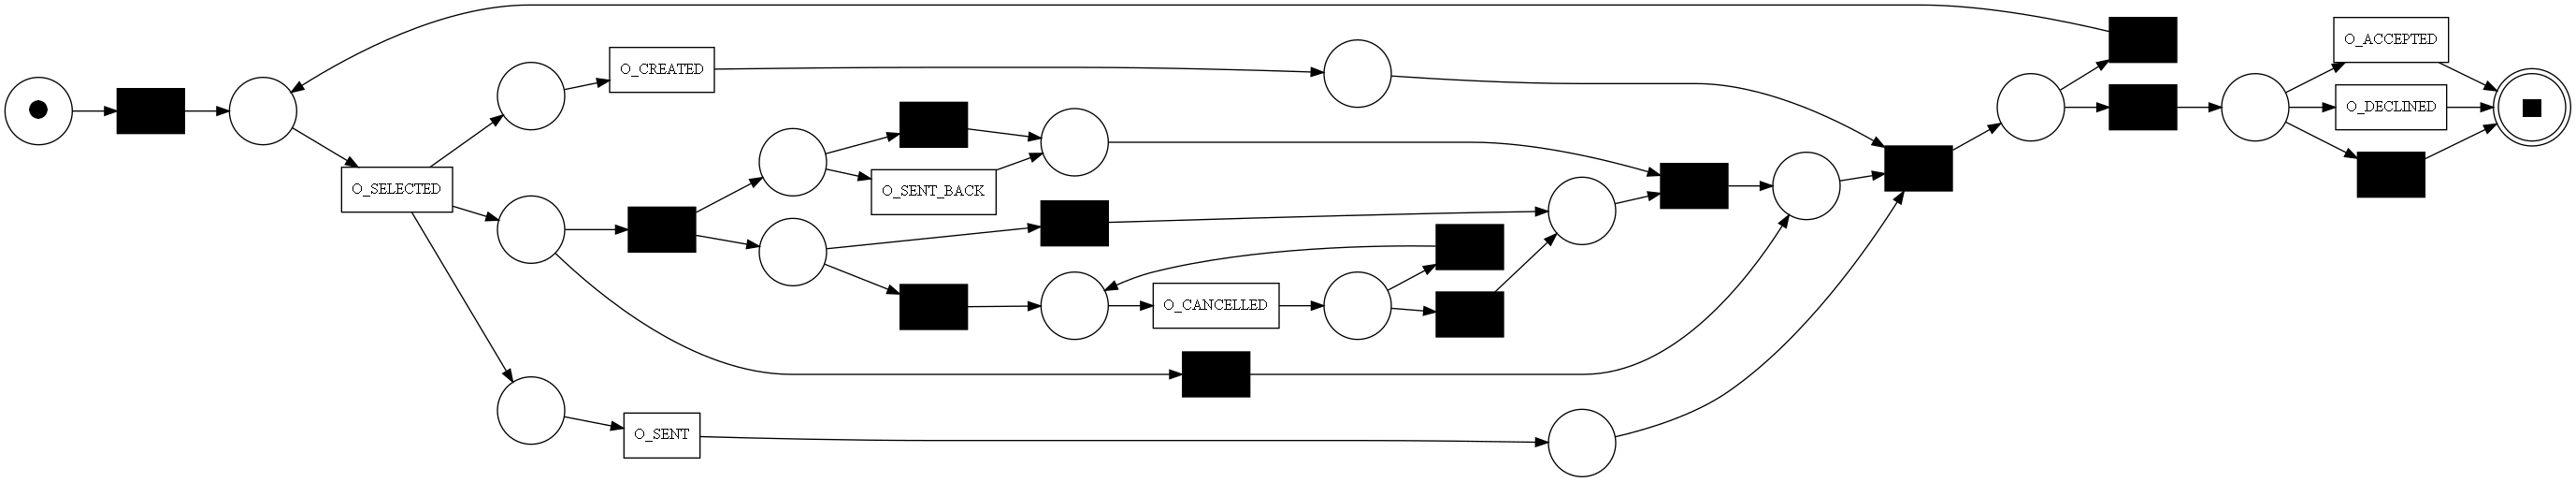

In [32]:
from exdpn.petri_net import get_petri_net

net, im, fm = get_petri_net(log, miner_type='IM')
pm4py.view_petri_net(net, im, fm)

As we can see, we have three decision points in our log / the corresponding Petri net.
We now take all trace-level and event-level attributes that do not have ID-esque semantics:

In [33]:
event_attrs = list(pm4py.get_event_attributes(log))
trace_attrs = list(pm4py.get_trace_attributes(log))

In [34]:
trace_attrs.remove("REG_DATE")

In [35]:
event_attrs = [attr for attr in event_attrs if max(list(pm4py.get_event_attribute_values(log, attr).values())) != 1 and "ID" not in attr]
event_attrs.remove("time:timestamp")
event_attrs.remove("concept:name")

Initialize ML techniques with reasonable parameters. We provide the `min_impurity_decrease` parameter to the DT model to assure explainability, since otherwise the trees would become enormously large and thus would not allow us to derive explanations in practice.

In [54]:
from exdpn.data_petri_net import Data_Petri_Net
from exdpn.guards import ML_Technique

ml_list = [ML_Technique.DT, ML_Technique.XGB, ML_Technique.NN]

dpn = Data_Petri_Net(log, petri_net=net, initial_marking=im, final_marking=fm,
                     event_level_attributes=event_attrs,
                     case_level_attributes=trace_attrs,
                     ml_list=ml_list, 
                     verbose=True, 
                     impute=True,
                     CV_splits=3,
                     hyperparameters={ML_Technique.NN: {'hidden_layer_sizes': (5,), 'learning_rate': 'adaptive'},
                                      ML_Technique.DT: {'min_impurity_decrease': 0.01},
                                      ML_Technique.LR: {'C': 0.1375, 'tol': 0.001},
                                      ML_Technique.SVM: {'C': 0.3, 'tol': 0.001},
                                      ML_Technique.XGB: {'max_depth': 2, 'n_estimators': 20},
                                      ML_Technique.RF:  {'max_depth': 5, 'min_impurity_decrease': 0.0}}, 
                     numeric_attributes=["AMOUNT_REQ"])

-> Mining guard datasets... Done
-> Evaluating guards at decision point 'p_6'... 

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


Done
-> Evaluating guards at decision point 'p_19'... 

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


Done
-> Evaluating guards at decision point 'p_4'... 

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


Done
-> Evaluating guards at decision point 'p_16'... Done
-> Evaluating guards at decision point 'p_12'... Done
-> Evaluating guards at decision point 'p_14'... 

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


Done


In [55]:
best = dpn.get_best()

-> Best machine learning technique at decision point 'p_6': Neural Network w/ performance 0.8163911307423143
-> Best machine learning technique at decision point 'p_19': XGBoost w/ performance 0.9388403089351011
-> Best machine learning technique at decision point 'p_4': Neural Network w/ performance 0.7596401138997343
-> Best machine learning technique at decision point 'p_16': Decision Tree w/ performance 0.961219897529503
-> Best machine learning technique at decision point 'p_12': Neural Network w/ performance 0.7979727573891248
-> Best machine learning technique at decision point 'p_14': Neural Network w/ performance 0.9696672486876096


In [56]:
import pandas as pd

res = pd.DataFrame(columns=["place"] + [str(ml_t for ml_t in ml_list)])

for dp,gm in dpn.guard_manager_per_place.items():
    res_row = {"place": dp} | {str(ml_t):gm.guards_results_mean[ml_t] for ml_t in gm.guards_list.keys()}
    res = res.append([res_row])
    
res['place'] = res['place'].apply(str)
res.index = res["place"]
res.drop(["place"], axis=1, inplace=True)
res.dropna(axis=1, how="all", inplace=True)

In [57]:
res.transpose()

place,p_6,p_19,p_4,p_16,p_12,p_14
Decision Tree,0.745796,0.925841,0.730227,0.961220,0.795512,0.963370
XGBoost,0.772423,0.938840,0.751318,0.961220,0.796183,0.966239
Neural Network,0.816391,0.930347,0.759640,0.959899,0.797973,0.969667


<AxesSubplot:xlabel='place'>

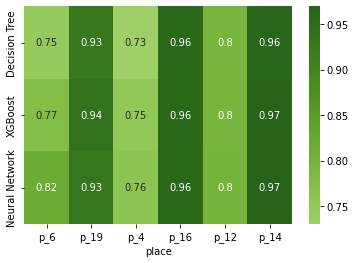

In [58]:
import seaborn as sns

sns.heatmap(res.transpose(), annot=True, cmap="PiYG", center=0.5)

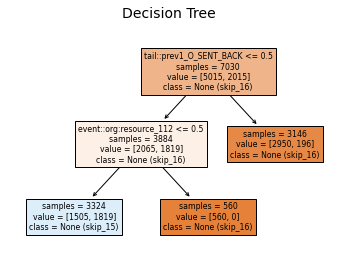

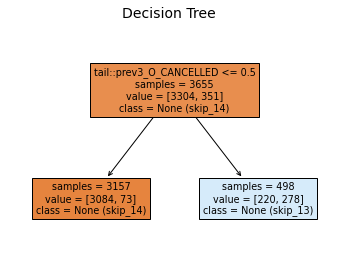

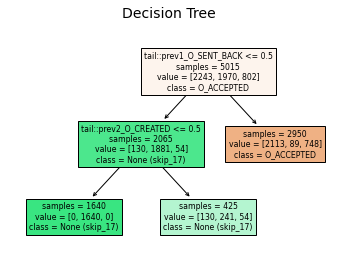

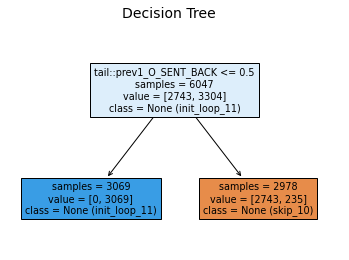

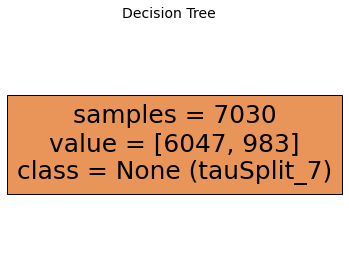

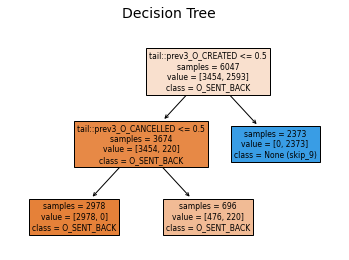

In [59]:
for _, gm in dpn.guard_manager_per_place.items():
    gm.guards_list[ML_Technique.DT].get_explainable_representation()